In [12]:
import pyrogue.utilities.fileio as fileio
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import norm
from scipy.optimize import curve_fit
top_level=f'{os.getcwd()}/..'
from datetime import datetime
import glob
import re
import time
import struct
import pandas as pd
import seaborn as sns
#from scipy.fft import fft,fftfreq
from scipy.signal import firwin, lfilter, freqz
from tslearn.metrics import dtw
from tslearn.clustering import TimeSeriesKMeans
from scipy.stats import skew, kurtosis, pearsonr
from scipy.fftpack import fft
from statsmodels.tsa.stattools import acf
from sklearn.linear_model import LinearRegression
from scipy.signal import find_peaks

In [13]:
DV_filename=['data_20240323_091420', 'data_20240405_182849', 'data_20240401_221706', 'data_20240413_005829', 'data_20240309_115540', 'data_20240327_190358', 'data_20240405_024853', 'data_20240322_200311', 'data_20240406_104928', 'data_20240402_054532', 'data_20240416_000609', 'data_20240331_160053', 'data_20240307_191034', 'data_20240330_010639', 'data_20240414_024721', 'data_20240412_201042', 'data_20240411_023343', 'data_20240328_052654', 'data_20240328_190230', 'data_20240409_041622', 'data_20240322_234317', 'data_20240411_183727', 'data_20240405_233122', 'data_20240323_171747', 'data_20240324_194847', 'data_20240322_033232', 'data_20240325_180554', 'data_20240411_231200', 'data_20240331_080708', 'data_20240323_070827', 'data_20240414_211104', 'data_20240412_215932', 'data_20240324_204715', 'data_20240321_221813', 'data_20240413_180833', 'data_20240412_190229', 'data_20240402_192213', 'data_20240330_153919', 'data_20240406_085328', 'data_20240414_075533', 'data_20240415_090346', 'data_20240405_112729', 'data_20240325_070032', 'data_20240322_220131', 'data_20240414_053323', 'data_20240326_214035', 'data_20240325_121601', 'data_20240406_220945', 'data_20240412_182846', 'data_20240401_072513', 'data_20240323_154009', 'data_20240414_180023', 'data_20240323_101637', 'data_20240406_064757', 'data_20240323_134831', 'data_20240325_140736', 'data_20240404_054128', 'data_20240412_175016', 'data_20240309_115540', 'data_20240324_070921', 'data_20240329_045412', 'data_20240325_003115', 'data_20240324_115319', 'data_20240405_193102', 'data_20240405_205858']
DV_file_num=[0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
UV_filename=['data_20240405_182849', 'data_20240413_005829', 'data_20240405_024853', 'data_20240406_104928', 'data_20240416_000609', 'data_20240414_024721', 'data_20240412_201042', 'data_20240411_023343', 'data_20240409_041622', 'data_20240411_183727', 'data_20240405_233122', 'data_20240411_231200', 'data_20240414_211104', 'data_20240412_215932', 'data_20240413_180833', 'data_20240412_190229', 'data_20240402_192213', 'data_20240406_085328', 'data_20240414_075533', 'data_20240415_090346', 'data_20240405_112729', 'data_20240414_053323', 'data_20240406_220945', 'data_20240412_182846', 'data_20240414_180023', 'data_20240406_064757', 'data_20240404_054128', 'data_20240412_175016', 'data_20240405_193102', 'data_20240405_205858']
UV_file_num=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [14]:
def datfile(filename):
    # Waveforms variables to be filled 
    ampFault = { i : []  for i in range(4) }  
    xPosFault = []
    yPosFault = []
    qBunchFault = []
    recordtime = []
    
    # Open the .dat file
    with fileio.FileReader(files='../datfile/'+filename) as fd:
        
        # Loop through the file data
        for header,data in fd.records():
    
            # Check if there is a 8-byte header in the frame
            if (header.flags==0):
                hdrOffset = 8
                hdr = struct.unpack("<d", data[:8])[0]
                timestamp = time.localtime(hdr)
                # Define the desired format string (replace with your preferred format)
                # Some common format specifiers:
                # %Y - Year with century
                # %m - Month as a decimal number (01-12)
                # %d - Day of the month as a decimal number (01-31)
                # %H - Hour in 24-hour format (00-23)
                # %M - Minute (00-59)
                # %S - Second (00-59)
                
                formatted_time = time.strftime('%Y-%m-%d_%H-%M-%S', timestamp)
                #print( f'CH={header.channel}: Event Timestamp in human-readable format: {formatted_time}' )
                if header.channel==24:
                    recordtime.append(formatted_time)
            
            else:
                hdrOffset = 0
                print( 'No timestamp header detected' )
                return 0,0
            
            # Check for error in frame
            if (header.error>0):
                # Look at record header data
                print(f"Processing record. Total={fd.totCount}, Current={fd.currCount}")
                print(f"Record size    = {header.size}")
                print(f"Record channel = {header.channel}")
                print(f"Record flags   = {header.flags:#x}")
                print(f"Record error   = {header.error:#x}")
    
            # Check if AMP Fault waveform
            elif (header.channel < 16) and (header.channel >= 12):
                ampFault[header.channel-12].append(data[hdrOffset:].view(np.int16))
    
            # Check if AMP Live waveform
            elif header.channel == 24:
                fpData = data[hdrOffset:].view(np.float32)
                fpDataLen = len(fpData)
                xPosFault.append(   fpData[0:(fpDataLen*3)+0:3] ) 
                yPosFault.append(   fpData[1:(fpDataLen*3)+1:3] )
                qBunchFault.append( fpData[2:(fpDataLen*3)+2:3] )
            
            # Else undefined stream index
            else:
                print( f'UNDEFINED DATA STREAM[{header.channel}]!!!')
    return ampFault, recordtime

In [15]:
def parse_and_plot_MA_DV(filename,num):
    ampFault, recordtime = datfile(filename+'.dat')
    if recordtime==0:
        return
    if len(recordtime)==0:
        return
    #print(len(recordtime))
    #print(f'Selected time : {recordtime[num]}')

    def bunchindex(threshold,waveform):
        start=12800
        firstbunch=0
        for i in range(1,8*5120):
            if waveform[start+i-1]<waveform[start+i] and waveform[start+i]>waveform[start+i+1]:
                if waveform[start+i]>threshold:
                    firstbunch=start+i
                    break
        if firstbunch==0:
            print("invalid data")
            return firstbunch, 0
    
        bunch_candidate=waveform[firstbunch:firstbunch+5120*8:8]
        bunch_index=np.where(bunch_candidate>threshold)[0]
    
        return firstbunch, bunch_index

    firstbunch, bunch_index=bunchindex(1000,ampFault[0][num])
    if firstbunch==0:
        print(f"end process: DV{filename}_{num}")
        return

    #print(f'Downstream Num of bunch : {len(bunch_index)}')
    #print(f'Downstream First bunch index : {firstbunch}')

    if firstbunch>140000:
        return

    start=12800
    y_pos=[]
    charge=[]
    for j in bunch_index:
        certain_bunch=[]
        certain_bunch_charge=[]
        for i in range(12):
            sum=ampFault[0][num][firstbunch+j*8+5120*8*i]
            delta=ampFault[1][num][firstbunch+j*8+5120*8*i]
            yposition=delta/sum*16.58/5+1.6
            certain_bunch.append(yposition)
            certain_bunch_charge.append(sum)
        y_pos.append(np.array(certain_bunch))
        charge.append(np.array(certain_bunch_charge))
    y_pos=np.array(y_pos)
    charge=np.array(charge)

    mean=np.mean(y_pos[:,0:2],axis=1)
    y_pos=y_pos-mean[:,np.newaxis]
    mean=np.mean(charge[:,0:2],axis=1)
    charge=charge/mean[:,np.newaxis]
    #print(y_pos[:,-3:])
    #print(charge)
    y_first_turn=np.concatenate(y_pos[:,3:5])
    y_last_turn=np.concatenate(y_pos[:,-3:])
    loss=1-np.min(np.concatenate(charge))
    
    #make x axis
    bunch_index_12=[]
    for i in range(12):
        bunch_index_12.append(bunch_index+5120*i)

    x_axis=np.concatenate(bunch_index_12)/5120+1
        
    split=np.hsplit(y_pos,y_pos.shape[1])
    pos=np.concatenate(split).flatten()
    
    return pos,len(bunch_index)

In [48]:
all_data=[]
for i in range(65):
    a,b=parse_and_plot_MA_DV(DV_filename[i],DV_file_num[i])
    if b==2346:
        all_data.append(a[2346*2:])

In [49]:
df=pd.DataFrame(all_data)

In [50]:
df.iloc[0]

0        0.050934
1        0.025417
2       -0.059128
3       -0.031316
4       -0.015592
           ...   
23455    0.002814
23456   -0.026406
23457   -0.002232
23458    0.021872
23459    0.014337
Name: 0, Length: 23460, dtype: float64

In [51]:
# フラクタル次元の計算関数
def hurst_exponent(ts):
    lags = range(2, 100)
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    reg = np.polyfit(np.log(lags), np.log(tau), 1)
    return reg[0]*2.0

# 特徴量抽出関数
def extract_features(row):
    row_series = pd.Series(row)
    features = {
        'mean': np.mean(row),
        'std': np.std(row),
        'min': np.min(row),
        'max': np.max(row),
        'range': np.max(row) - np.min(row),
        'median': np.median(row),
        '25th_percentile': np.percentile(row, 25),
        '75th_percentile': np.percentile(row, 75),
        'iqr': np.percentile(row, 75) - np.percentile(row, 25),
        'skewness': skew(row),
        'kurtosis': kurtosis(row),
        'mean_diff': np.mean(np.diff(row)),
        'std_diff': np.std(np.diff(row)),
        'max_diff': np.max(np.diff(row)),
        'min_diff': np.min(np.diff(row)),
        'mean_moving_avg': np.mean(row_series.rolling(window=5).mean().dropna()),
        'std_moving_avg': np.std(row_series.rolling(window=5).mean().dropna()),
        'autocorrelation': acf(row, nlags=1)[1],  # 1時差の自己相関
        #'hurst_exponent': hurst_exponent(row),  # フラクタル次元
        'energy': np.sum(row**2),  # エネルギー
        'entropy': -np.sum(row * np.log2(row + 1e-10)),  # エントロピー
        #'fft_real_mean': np.mean(np.real(fft(row))),  # フーリエ変換の実数部の平均
        #'fft_imag_mean': np.mean(np.imag(fft(row))),  # フーリエ変換の虚数部の平均
        #'fft_real_std': np.std(np.real(fft(row))),  # フーリエ変換の実数部の標準偏差
        #'fft_imag_std': np.std(np.imag(fft(row))),  # フーリエ変換の虚数部の標準偏差
        'positive_values_count': np.sum(row > 0),  # 正の値の数
        'negative_values_count': np.sum(row < 0),  # 負の値の数
    }
    
    # 線形トレンドの傾きと切片
    X = np.arange(len(row)).reshape(-1, 1)
    y = row
    reg = LinearRegression().fit(X, y)
    features['trend_slope'] = reg.coef_[0]
    features['trend_intercept'] = reg.intercept_

    # 最大・最小遅延自己相関
    autocorr = acf(row, nlags=10)
    features['max_autocorr'] = np.max(autocorr[1:])
    features['min_autocorr'] = np.min(autocorr[1:])

    # ピアソン相関
    window_size = 5
    rolling_corr = row_series.rolling(window=window_size).corr().dropna()
    features['mean_rolling_corr'] = np.mean(rolling_corr)
    features['std_rolling_corr'] = np.std(rolling_corr)

    # 加速度の統計量
    acceleration = np.diff(np.diff(row))
    features['mean_acceleration'] = np.mean(acceleration)
    features['std_acceleration'] = np.std(acceleration)
    features['max_acceleration'] = np.max(acceleration)
    features['min_acceleration'] = np.min(acceleration)
    
    # ピークと谷の数
    peaks, _ = find_peaks(row)
    troughs, _ = find_peaks(-row)
    features['num_peaks'] = len(peaks)
    features['num_troughs'] = len(troughs)

    # 周期性の評価
    #fft_vals = np.abs(fft(row))
    #freqs = np.fft.fftfreq(len(fft_vals))
    #features['dominant_freq'] = freqs[np.argmax(fft_vals[1:]) + 1]  # DC成分を除く

    # ウィンドウ間のピアソン相関
    if len(row) > window_size:
        corr_matrix = np.corrcoef(row[:window_size], row[-window_size:])
        features['windowed_pearson_corr'] = corr_matrix[0, 1]

    return pd.Series(features)


In [52]:
extract_features(df.iloc[10])

/home/nomaru/anaconda3/envs/rogue_tag/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


mean                    -1.830036e-03
std                      3.800308e-02
min                     -1.891696e-01
max                      2.123749e-01
range                    4.015445e-01
median                  -1.563667e-03
25th_percentile         -2.493728e-02
75th_percentile          2.153538e-02
iqr                      4.647266e-02
skewness                -6.224435e-02
kurtosis                 1.300529e+00
mean_diff               -1.179156e-06
std_diff                 5.299309e-02
max_diff                 2.725852e-01
min_diff                -2.674422e-01
mean_moving_avg         -1.828056e-03
std_moving_avg           1.765919e-02
autocorrelation          2.776409e-02
energy                   3.396030e+01
entropy                  1.498108e+03
positive_values_count    1.133000e+04
negative_values_count    1.212800e+04
trend_slope              7.355857e-08
trend_intercept         -2.692841e-03
max_autocorr             2.776409e-02
min_autocorr             7.807473e-04
mean_rolling

In [53]:
# 各行から特徴量を抽出
features_df = df.apply(extract_features, axis=1)
features_df.head()

/home/nomaru/anaconda3/envs/rogue_tag/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nomaru/anaconda3/envs/rogue_tag/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nomaru/anaconda3/envs/rogue_tag/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nomaru/anaconda3/envs/rogue_tag/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nomaru/anaconda3/envs/rogue_tag/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home

,mean,std,min,max,range,median,25th_percentile,75th_percentile,iqr,skewness,...,min_autocorr,mean_rolling_corr,std_rolling_corr,mean_acceleration,std_acceleration,max_acceleration,min_acceleration,num_peaks,num_troughs,windowed_pearson_corr
0,0.004673,0.025696,-0.103166,0.124394,0.227561,0.004676,-0.012303,0.021589,0.033892,-0.015001,...,0.090480,1.0,3.316104e-14,7.665603e-07,0.058777,0.271515,-0.235543,7742.0,7742.0,-0.380186
1,0.010521,0.046898,-0.261220,0.254192,0.515412,0.007746,-0.017458,0.035192,0.052650,0.417372,...,0.253968,1.0,4.415220e-14,2.373652e-06,0.094987,0.607040,-0.546167,7764.0,7765.0,0.852889
2,-0.003727,0.029030,-0.139586,0.140373,0.279959,-0.003373,-0.021695,0.014396,0.036091,0.017647,...,0.231837,1.0,1.544100e-13,-5.129536e-07,0.060619,0.311317,-0.263940,7821.0,7821.0,-0.062981
3,0.007154,0.039283,-0.229186,0.284580,0.513766,0.001339,-0.013013,0.018899,0.031911,1.189637,...,0.795519,1.0,1.590520e-13,1.751797e-08,0.040940,0.239577,-0.280945,7820.0,7820.0,0.746578
4,0.006340,0.031629,-0.159515,0.171374,0.330888,0.005243,-0.013951,0.025511,0.039462,0.231361,...,0.378480,1.0,5.249036e-14,1.254280e-06,0.058004,0.279871,-0.269861,7804.0,7804.0,-0.606478


In [54]:
features_df

,mean,std,min,max,range,median,25th_percentile,75th_percentile,iqr,skewness,...,min_autocorr,mean_rolling_corr,std_rolling_corr,mean_acceleration,std_acceleration,max_acceleration,min_acceleration,num_peaks,num_troughs,windowed_pearson_corr
0,0.004673,0.025696,-0.103166,0.124394,0.227561,0.004676,-0.012303,0.021589,0.033892,-0.015001,...,0.090480,1.0,3.316104e-14,7.665603e-07,0.058777,0.271515,-0.235543,7742.0,7742.0,-0.380186
1,0.010521,0.046898,-0.261220,0.254192,0.515412,0.007746,-0.017458,0.035192,0.052650,0.417372,...,0.253968,1.0,4.415220e-14,2.373652e-06,0.094987,0.607040,-0.546167,7764.0,7765.0,0.852889
2,-0.003727,0.029030,-0.139586,0.140373,0.279959,-0.003373,-0.021695,0.014396,0.036091,0.017647,...,0.231837,1.0,1.544100e-13,-5.129536e-07,0.060619,0.311317,-0.263940,7821.0,7821.0,-0.062981
3,0.007154,0.039283,-0.229186,0.284580,0.513766,0.001339,-0.013013,0.018899,0.031911,1.189637,...,0.795519,1.0,1.590520e-13,1.751797e-08,0.040940,0.239577,-0.280945,7820.0,7820.0,0.746578
4,0.006340,0.031629,-0.159515,0.171374,0.330888,0.005243,-0.013951,0.025511,0.039462,0.231361,...,0.378480,1.0,5.249036e-14,1.254280e-06,0.058004,0.279871,-0.269861,7804.0,7804.0,-0.606478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,0.004085,0.029239,-0.143704,0.146287,0.289991,0.003486,-0.014477,0.021678,0.036155,0.194735,...,0.348520,1.0,3.883832e-14,-8.901823e-07,0.056185,0.225305,-0.228772,7826.0,7825.0,-0.326353
58,0.003436,0.026024,-0.101516,0.129399,0.230915,0.003158,-0.013712,0.020248,0.033960,0.051820,...,0.061610,1.0,5.437207e-14,1.073097e-06,0.060762,0.237927,-0.257157,7909.0,7910.0,0.629243
59,0.006608,0.033297,-0.123523,0.163506,0.287029,0.005520,-0.015573,0.027407,0.042980,0.260378,...,0.400033,1.0,6.599388e-14,-1.052460e-06,0.061032,0.268995,-0.278694,7716.0,7716.0,0.721866
60,0.007974,0.067570,-0.312094,0.251280,0.563374,0.008119,-0.023927,0.045146,0.069073,-0.407040,...,0.818190,1.0,3.764043e-13,-4.821429e-06,0.065570,0.335599,-0.320185,7814.0,7813.0,0.280364


In [55]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_df)


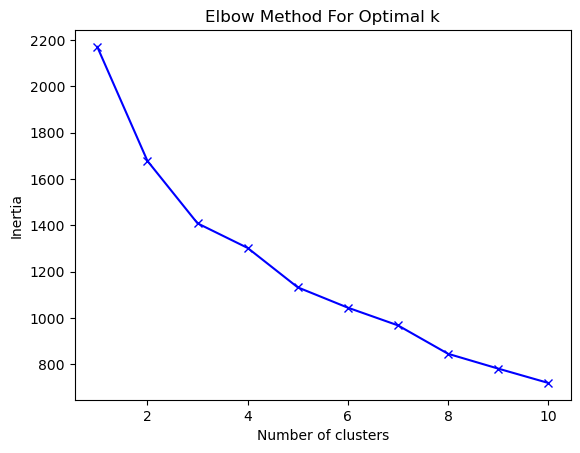

In [62]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# エルボー法で最適なクラスター数を決定
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

# 最適なクラスター数でクラスタリング
optimal_k = 2  # 例として3を使用
kmeans = KMeans(n_clusters=optimal_k, random_state=0).fit(scaled_features)
clusters = kmeans.labels_


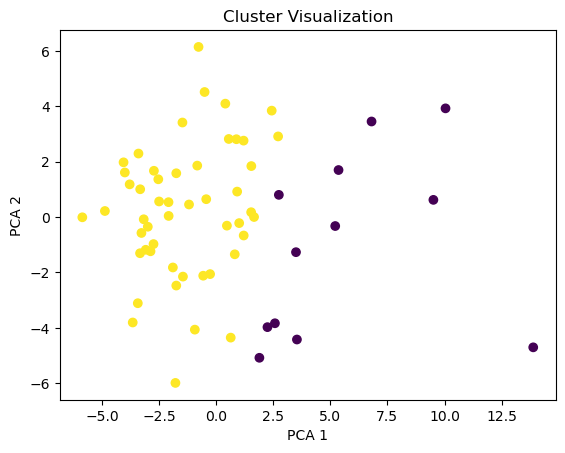

In [63]:
from sklearn.decomposition import PCA

# PCAで次元削減
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

# クラスタリング結果を可視化
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Cluster Visualization')
plt.show()
